In [1]:
# Import required packages
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rasterio as rio
import pandas as pd
import earthpy.plot as ep

# Set font sizes for plots
plt.rc('figure', titlesize=24)
plt.rc('axes', titlesize=16)

# Set area of interest and define paths
combined_path = '..\\data\\combined\\'
koumassi_aoi = "koumassi_focus_ps"
koumassi_band_path = '..\\data\\'+koumassi_aoi+"\\"
koumassi_threshold_outputs_path = os.path.join(
    koumassi_band_path, "final_outputs\\threshold\\")
koumassi_svm_outputs_path = os.path.join(
    koumassi_band_path, "final_outputs\\svm\\")
koumassi_kmeans_outputs_path = os.path.join(
    koumassi_band_path, "final_outputs\\kmeans\\")

southeast_aoi = "southeast_ps"
southeast_band_path = '..\\data\\'+southeast_aoi+"\\"
southeast_threshold_outputs_path = os.path.join(
    southeast_band_path, "final_outputs\\threshold\\")
southeast_svm_outputs_path = os.path.join(
    southeast_band_path, "final_outputs\\svm\\")
southeast_kmeans_outputs_path = os.path.join(
    southeast_band_path, "final_outputs\\kmeans\\")

 ## Out of the Shadows
 
 ### *Improving flood detection in urban environments by separating building shadows from flood waters*

Over the past 20 years, floods accounted for 43% of all recorded disasters globally. Flooding events are expected to increase in frequency and extent due to the impacts of climate change, including a rise in heavy precipitation events, rapid spring snowmelt, and dramatic storm surge. Traditional flood mapping is an extensive and expensive endeavor, involving teams of engineers, modelers, and field personnel. Remote sensing, and specifically the availability of high-resolution satellite imagery which provides detailed aerial views of cities, offers a new way to examine urban disasters and define risk. Historical images can be rapidly analyzed to give a sense of frequency and extent of natural disasters such as floods. This information can be used to develop low-cost flood maps which can be used to ensure all residents of the potential flood plain are identified and updated regularly. Additionally, near real-time monitoring of flooding is possible as satellites provide regularly updated images on a relatively short time-scale. One of the challenges in identifying areas of flood in an urban environment is that shadows from cloud and buildings look visually similar to flood waters and can be misidentified. 

In partnership with Cloud to Street, a company focused on providing flood information to low- and middle-income countries, this research project aimed to explore Python-based methods to improve the detection of floods in urban environments, with a specific focus on better differentiating between building shadows and flood waters. The study image was from DigitalGlobe's WorldView-2 satellite of a flooding event in Abidjan, Ivory Coast on June 17th, 2016. Two sub-sections of the city were selected as focus areas. The first, in the Koumassi region of the city represented a highly built-up urban area. The second, in the Southeast section of the city, represented lower lying wetland terrain. Each method was validated using a reference data set. Several methods were explored:

-	Thresholding spectral indices
-	Supervised machine learning: Support Vector Machine (SVM)
-	Unsupervised machine learning: K-means Clustering

<img src="Study_area.png">

**Figure 1.** Study map of Abidjan, Ivory Coast, highlighting the two areas of interest: Koumassi and Southeast.

## Mixed Results with Traditional Thresholding Approach

The first approach involved thresholding established spectral indices to identify water, building shadow, vegetation and buildings. The resulting threshold maps had accuracy scores of 67% and 79% for Koumassi and Southeast, respectively. The complementary confusion matrices show when the thresholding model results match with the reference data (signal along the diagonal) and where there is confusion between true and modeled results (signal off the diagonal). Based on the resulting maps and accuracy scores, it appears that the thresholding method is most appropriate for less urban environments due to the confusion between flood waters and building shadow.

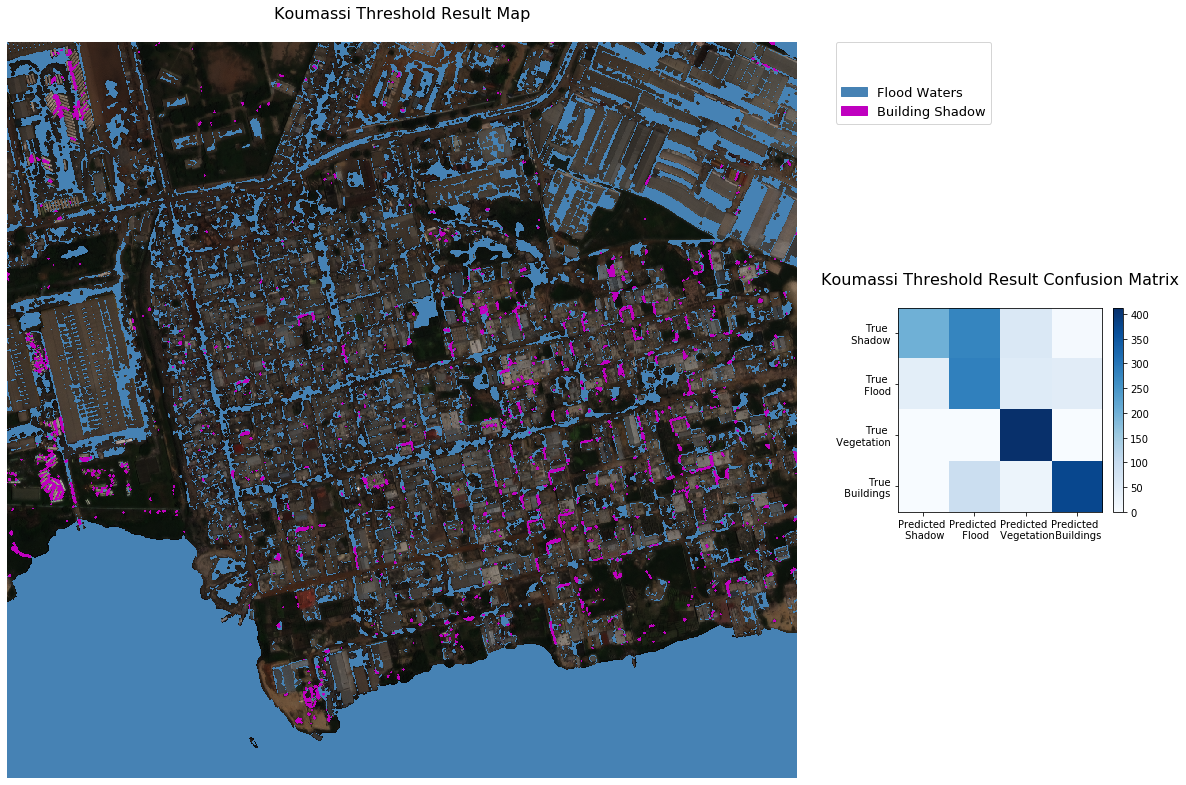

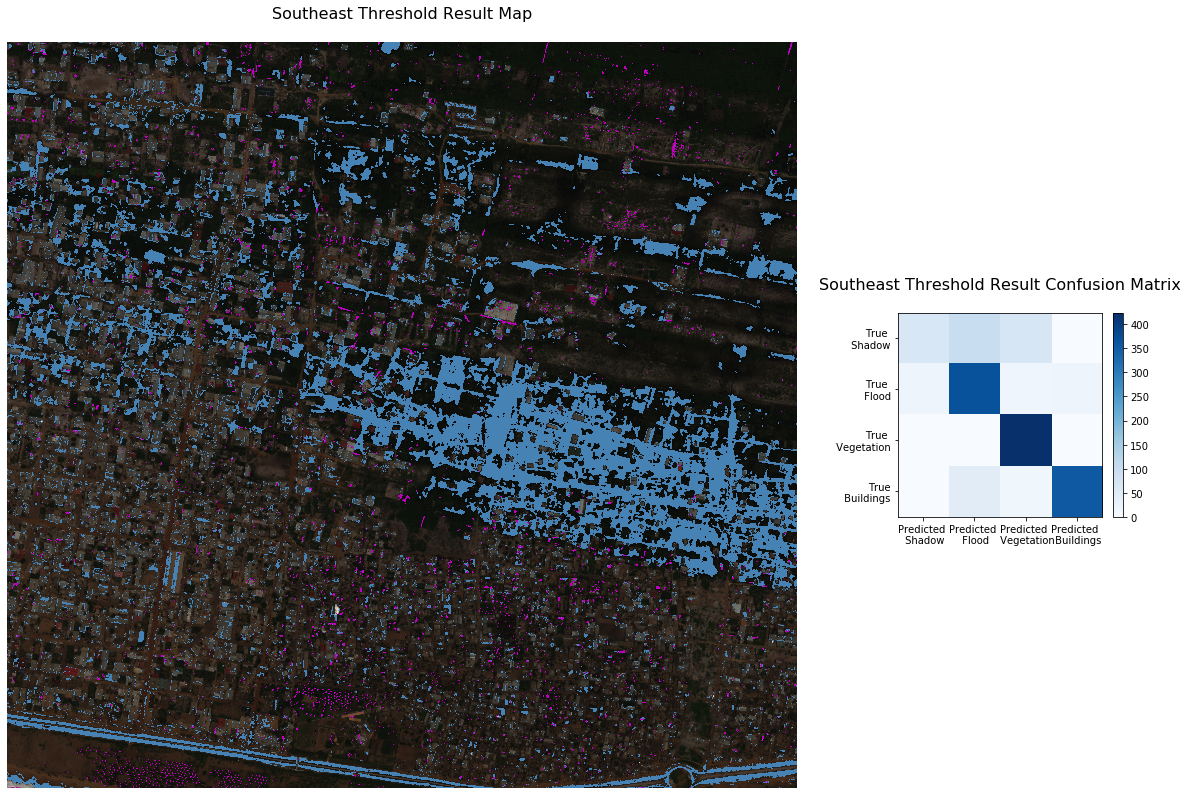

In [2]:
# Import threshold maps and confusion matrices for plotting
koumassi_threshold_path = os.path.join(
    koumassi_threshold_outputs_path, "koumassi_threshold_map.tif")
koumassi_rgb_path = os.path.join(
    koumassi_threshold_outputs_path, "koumassi_focus_ps_rgb_bands.tif")
with rio.open(koumassi_threshold_path) as src:
    koumassi_threshold_map = src.read()
koumassi_threshold_map = np.squeeze(koumassi_threshold_map)
with rio.open(koumassi_rgb_path) as src:
    koumassi_rgb_map = src.read()

southeast_threshold_path = os.path.join(
    southeast_threshold_outputs_path, "southeast_threshold_map.tif")
southeast_rgb_path = os.path.join(
    southeast_threshold_outputs_path, "southeast_ps_rgb_bands.tif")
with rio.open(southeast_threshold_path) as src:
    southeast_threshold_map = src.read()
southeast_threshold_map = np.squeeze(southeast_threshold_map)
with rio.open(southeast_rgb_path) as src:
    southeast_rgb_map = src.read()

koumassi_confusion_threshold = pd.read_csv(
    koumassi_threshold_outputs_path+'koumassi_threshold_confusion.csv')
koumassi_confusion_threshold = koumassi_confusion_threshold.drop(
    koumassi_confusion_threshold.columns[[0]], axis=1)
koumassi_confusion_threshold_plot = koumassi_confusion_threshold.values
koumassi_confusion_threshold_plot = koumassi_confusion_threshold_plot[0:4, 0:4]

southeast_confusion_threshold = pd.read_csv(
    southeast_threshold_outputs_path+'southeast_threshold_confusion.csv')
southeast_confusion_threshold = southeast_confusion_threshold.drop(
    southeast_confusion_threshold.columns[[0]], axis=1)
southeast_confusion_threshold_plot = southeast_confusion_threshold.values
southeast_confusion_threshold_plot = southeast_confusion_threshold_plot[0:4, 0:4]

# Plot threshold map and confusion matrix for Koumassi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(
    20, 15), gridspec_kw={'width_ratios': [3.5, 1]})
ep.plot_rgb(koumassi_rgb_map, rgb=(2, 1, 0), ax=ax1)
cmap = ListedColormap(['none', 'none', 'none', 'steelblue', 'm'])
plt.setp(ax2, xticks=np.arange(4), xticklabels=['Predicted \n Shadow', 'Predicted \n Flood',
                                                'Predicted \n Vegetation', 'Predicted \n Buildings'],
         yticks=np.arange(4), yticklabels=['True \n Shadow', 'True \n Flood',
                                           'True \n Vegetation', 'True\n Buildings'])
labels = ['', '', 'Flood Waters', 'Building Shadow']
im = ax1.imshow(koumassi_threshold_map, cmap=cmap)
conf_mat = ax2.imshow(koumassi_confusion_threshold_plot,
                      cmap='Blues', interpolation='nearest')
ax1.set(title="Koumassi Threshold Result Map\n")
ax2.set(title="Koumassi Threshold Result Confusion Matrix\n")
divider = make_axes_locatable(ax2)
ep.draw_legend(im, titles=labels, classes=[0, 1, 2, 3])
cax1 = divider.append_axes("right", size="5%", pad=0.15)
fig.colorbar(conf_mat, cax=cax1)
ax1.set_axis_off()
plt.show()


# Plot threshold map and confusion matrix for Southeast
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(
    20, 15), gridspec_kw={'width_ratios': [3.5, 1]})
ep.plot_rgb(southeast_rgb_map, rgb=(2, 1, 0), ax=ax1)
cmap = ListedColormap(['none', 'none', 'none', 'steelblue', 'm'])
plt.setp(ax2, xticks=np.arange(4), xticklabels=['Predicted \n Shadow', 'Predicted \n Flood',
                                                'Predicted \n Vegetation', 'Predicted \n Buildings'],
         yticks=np.arange(4), yticklabels=['True \n Shadow', 'True \n Flood',
                                           'True \n Vegetation', 'True\n Buildings'])
im = ax1.imshow(southeast_threshold_map, cmap=cmap)
conf_mat = ax2.imshow(southeast_confusion_threshold_plot,
                      cmap='Blues', interpolation='nearest')
ax1.set(title="Southeast Threshold Result Map\n")
ax2.set(title="Southeast Threshold Result Confusion Matrix\n")
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes("right", size="5%", pad=0.15)
fig.colorbar(conf_mat, cax=cax1)
ax1.set_axis_off()
plt.show()

**Figure 2.** For each of the two study areas: Koumassi and Southeast, the threshold result map shows the extent of flooding (in blue), along with areas of building shadow (in pink). The confusion matrix for the Koumassi site shows frequent confusion between true shadow and predicted flood. The confusion matrix for the Southeast site also shows miscategorization between shadows and flood, though less frequently. 

## Supervised Machine Learning Performs Best

The support vector machine (SVM) classifier, a supervised machine learning approach, was examined next. Inputs to the SVM model were selected after exploring various combinations of raw spectral bands and index values and include data from both Koumassi and Southeast sites. Supervised machine learning methods require a training data set, with known values of the classes of interest to define the classifier. In this case, developing a training data set required a detailed examination of the satellite image, with training points dropped on specific locations to identify building shadow and flood. Selecting model inputs and developing training data can be time intensive and is a reminder that **despite the power of machine learning methods, human inputs are imperative**! Once the models were trained and refined, they were validated on an external data set. The external validation accuracy score was 93%. Results for the supervised methods are promising and present a substantial improvement over the thresholding approach.

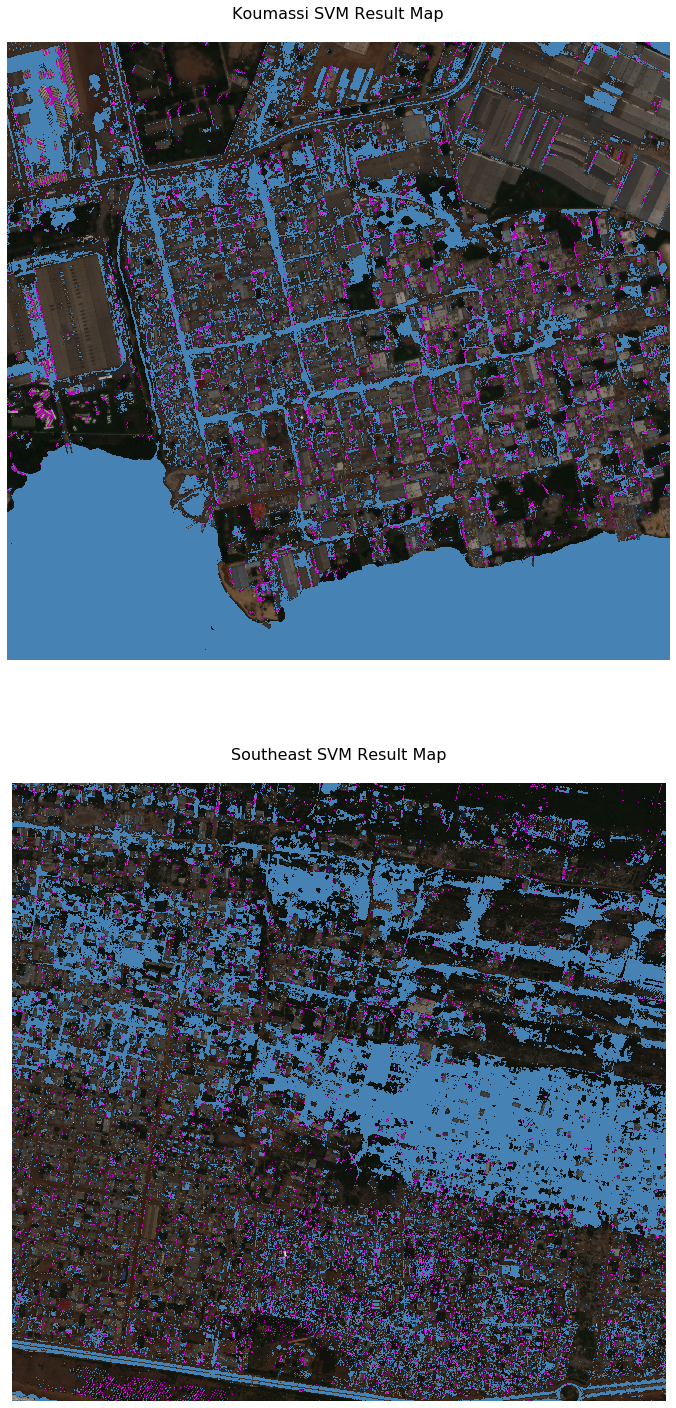

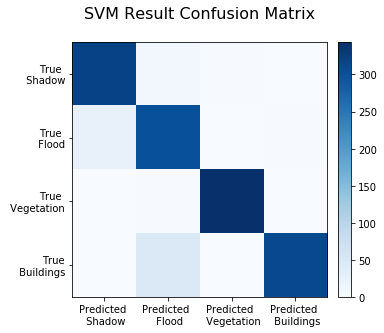

In [3]:
# Import SVM map and confusion matrix for plotting
koumassi_svm_path = os.path.join(
    combined_path, "koumassi_SVM_map_combined_final.tif")
with rio.open(koumassi_svm_path) as src:
    koumassi_svm_map = src.read()
koumassi_svm_map = np.squeeze(koumassi_svm_map)

southeast_svm_path = os.path.join(
    combined_path, "southeast_SVM_map_combined_final.tif")
with rio.open(southeast_svm_path) as src:
    southeast_svm_map = src.read()
southeast_svm_map = np.squeeze(southeast_svm_map)

confusion_svm = pd.read_csv(combined_path+'confusion_svm_external_additional_points_v4.csv')
confusion_svm = confusion_svm.drop(confusion_svm.columns[[0]], axis=1)
confusion_svm_plot = confusion_svm.values


# Plot SVM maps for Koumassi and Southeast
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(
    30, 25))
ep.plot_rgb(koumassi_rgb_map, rgb=(2, 1, 0), ax=ax1)
ep.plot_rgb(southeast_rgb_map, rgb=(2, 1, 0), ax=ax2)
cmap = ListedColormap(['m', 'steelblue', 'none', 'none'])
im = ax1.imshow(koumassi_svm_map, cmap=cmap)
im2 = ax2.imshow(southeast_svm_map, cmap=cmap)
ax1.set(title="Koumassi SVM Result Map\n")
ax2.set(title="Southeast SVM Result Map\n")
fig.colorbar(conf_mat, cax=cax1)
ax1.set_axis_off()
ax2.set_axis_off()
plt.show()

# # Plot confusion matrix for overall SVM model
fig, ax = plt.subplots(figsize=(5, 5))
plt.setp(ax, xticks=np.arange(4), xticklabels=['Predicted \n Shadow', 'Predicted \n Flood', 
                                               'Predicted \n Vegetation', 'Predicted \n Buildings'],
         yticks=np.arange(4), yticklabels=['True \n Shadow', 'True \n Flood', 
                                           'True \n Vegetation', 'True\n Buildings'])
conf_mat = ax.imshow(confusion_svm_plot, cmap='Blues',
                     interpolation='nearest')
ax.set(title="SVM Result Confusion Matrix\n")
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.15)
fig.colorbar(conf_mat, cax=cax1)
plt.show()

**Figure 3.** The SVM result map shows the modeled extent of flooding (in blue) within the study area, along with areas of building shadow (in pink). The confusion matrix shows that there is minor confusion between building shadow and flood, and buildings and flood.

## Unsupervised Machine Learning Performs Almost as Well!

Finally, k-means clustering, an unsupervised machine learning approach was explored. Unsupervised methods do not require a training data set, and instead rely on computer algorithms to find similarities within the inputs and automatically output clusters with similar characteristics. The input to the k-means model was the eight-band raster stack, and seven clusters were identified representing flood, shadow, buildings and vegetation. K-means clustering results had accuracy scores of 84% and 79% for Koumassi and Southeast, respectively. The k-means output shows substantial confusion between shadow and flood waters, especially in the pink "shadow" cluster as shown in Figure 4. While the k-means accuracy scores were not as high as the supervised machine learning model, k-means does not require a training data set to develop, meaning that substantially less effort is required to use these unsupervised approaches! 

<img src="Shadow_Confusion.png"> 

**Figure 4.** From the Koumassi k-means result. The bright pink "shadow" cluster includes both building shadow and flood water. The blue cluster is primarily flood water, grey clusters are buildings and the green cluster is vegetation. 

Additionally, improved visualizations and flood-only accuracy scores were developed by reassigning the pink "shadow" cluster as a second flood cluster and applying the thresholded shadow mask to the image. Flood only accuracy scores increased from 68% to 98% and 91% to 96% for Koumassi and Southeast, respectively. While not a perfect flood mapping tool on its own, applying the k-means method may provide additional information in the flood map preparation process.

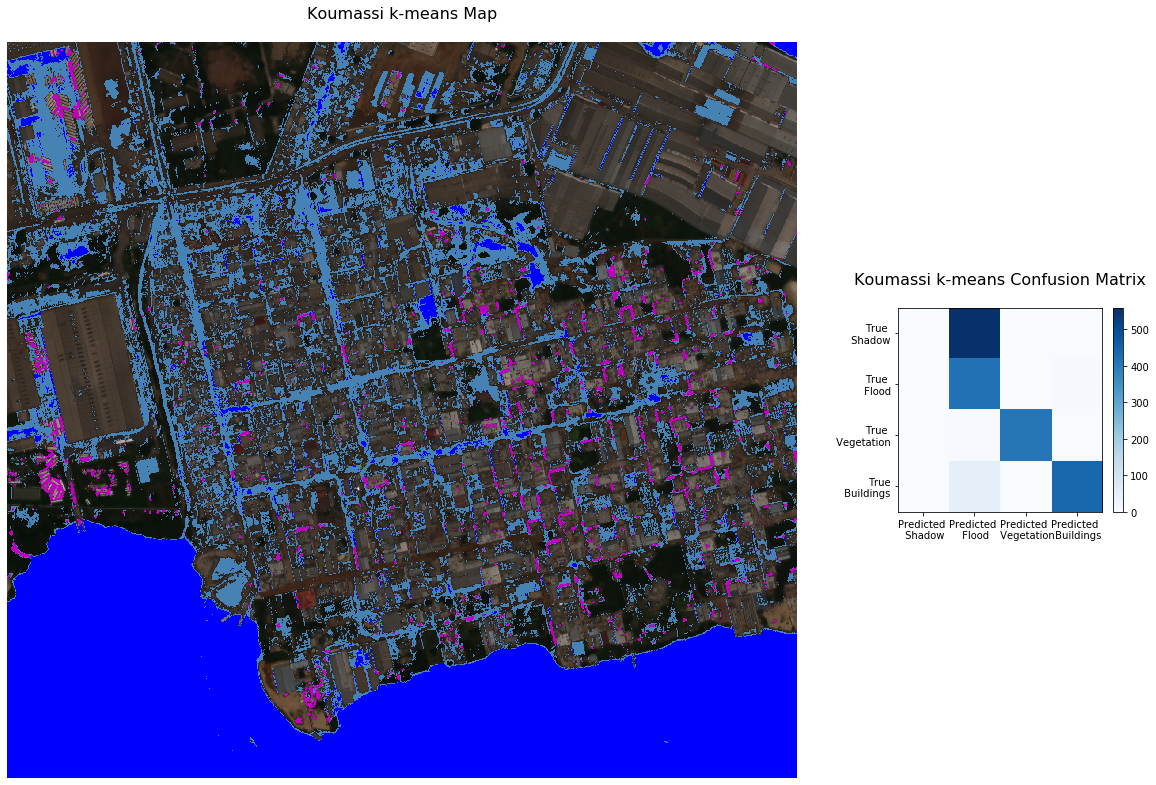

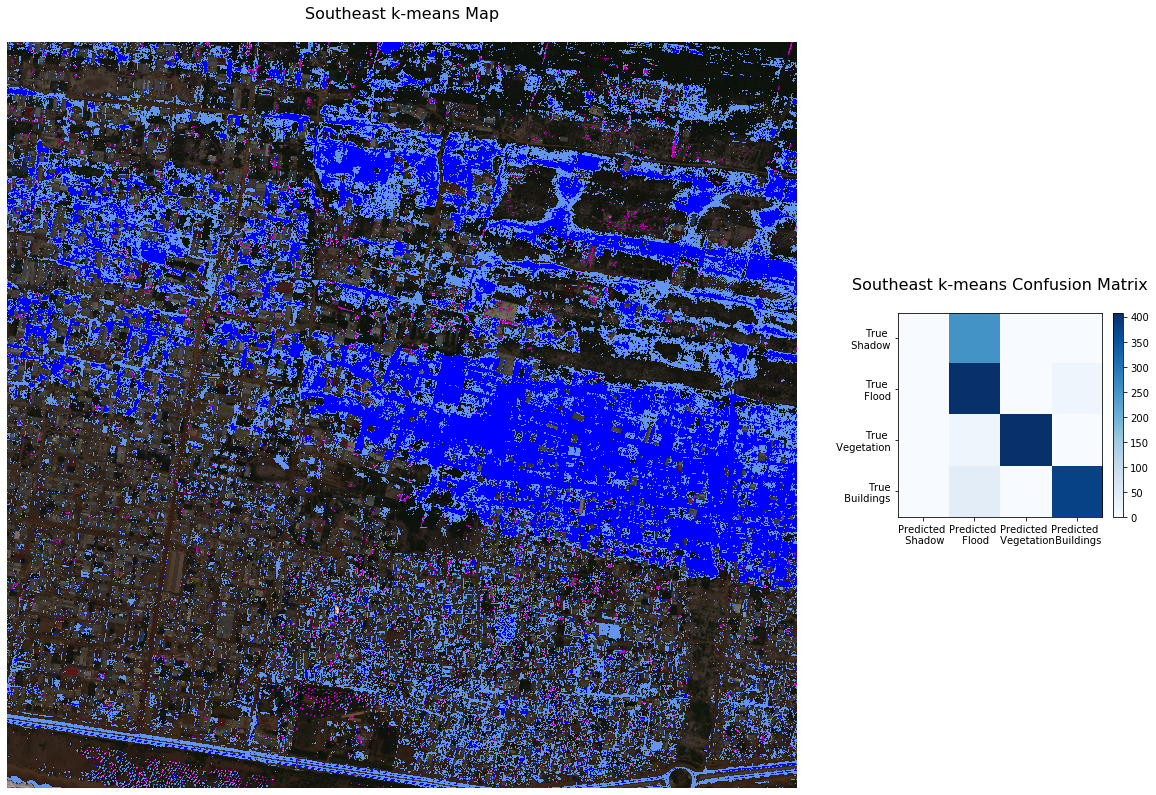

In [4]:
# Plot koumassi kmeans results
koumassi_kmeans_path = os.path.join(
    koumassi_kmeans_outputs_path, "koumassi_kmeans_all_bands.tif")
with rio.open(koumassi_kmeans_path) as src:
    koumassi_kmeans_map = src.read()
koumassi_kmeans_map = np.squeeze(koumassi_kmeans_map)

southeast_kmeans_path = os.path.join(
    southeast_kmeans_outputs_path, "southeast_kmeans_all_bands.tif")
with rio.open(southeast_kmeans_path) as src:
    southeast_kmeans_map = src.read()
southeast_kmeans_map = np.squeeze(southeast_kmeans_map)


koumassi_confusion_kmeans = pd.read_csv(
    koumassi_kmeans_outputs_path+'koumassi_kmeans_all_bands_confusion_all_no_shadow.csv')
koumassi_confusion_kmeans = koumassi_confusion_kmeans.drop(
    koumassi_confusion_kmeans.columns[[0]], axis=1)
koumassi_confusion_kmeans_plot = koumassi_confusion_kmeans.values

southeast_confusion_kmeans = pd.read_csv(
    southeast_kmeans_outputs_path+'southeast_kmeans_all_bands_confusion_all_no_shadow.csv')
southeast_confusion_kmeans = southeast_confusion_kmeans.drop(
    southeast_confusion_kmeans.columns[[0]], axis=1)
southeast_confusion_kmeans_plot = southeast_confusion_kmeans.values


# Plot koumassi kmeans map and confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(
    20, 15), gridspec_kw={'width_ratios': [3.5, 1]})
ep.plot_rgb(koumassi_rgb_map, rgb=(2, 1, 0), ax=ax1)
cmap = ListedColormap(['steelblue', 'none', 'none',
                       'blue', 'none', 'none', 'none'])
im = ax1.imshow(koumassi_kmeans_map, cmap=cmap)
shadow_cmap = ListedColormap(['none', 'none', 'none', 'none', 'm'])
ax1.imshow(koumassi_threshold_map, cmap=shadow_cmap)
ax1.set(title="Koumassi k-means Map\n")
ax1.set_axis_off()

# Plot confusion matrix
plt.setp(ax2, xticks=np.arange(4), xticklabels=['Predicted \n Shadow', 'Predicted \n Flood', 
                                                'Predicted \n Vegetation', 'Predicted \n Buildings'],
         yticks=np.arange(4), yticklabels=['True \n Shadow', 'True \n Flood', 
                                           'True \n Vegetation', 'True\n Buildings'])
conf_mat = ax2.imshow(koumassi_confusion_kmeans_plot,
                      cmap='Blues', interpolation='nearest')
ax2.set(title="Koumassi k-means Confusion Matrix\n")
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes("right", size="5%", pad=0.15)
fig.colorbar(conf_mat, cax=cax1)
ax1.set_axis_off()
plt.show()


# Plot southeast kmeans map and confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(
    20, 15), gridspec_kw={'width_ratios': [3.5, 1]})
ep.plot_rgb(southeast_rgb_map, rgb=(2, 1, 0), ax=ax1)
cmap = ListedColormap(['none', 'blue', 'cornflowerblue',
                       'none', 'none', 'none', 'none'])
plt.setp(ax2, xticks=np.arange(4), xticklabels=['Predicted \n Shadow', 'Predicted \n Flood', 
                                                'Predicted \n Vegetation', 'Predicted \n Buildings'],
         yticks=np.arange(4), yticklabels=['True \n Shadow', 'True \n Flood', 
                                           'True \n Vegetation', 'True\n Buildings'])
im = ax1.imshow(southeast_kmeans_map, cmap=cmap)
shadow_cmap = ListedColormap(['none', 'none', 'none', 'none', 'm'])
ax1.imshow(southeast_threshold_map, cmap=shadow_cmap)
ax1.set(title="Southeast k-means Map\n")

# Plot confusion matrix
conf_mat = ax2.imshow(southeast_confusion_kmeans_plot,
                      cmap='Blues', interpolation='nearest')
ax2.set(title="Southeast k-means Confusion Matrix\n")
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes("right", size="5%", pad=0.15)
fig.colorbar(conf_mat, cax=cax1)
ax1.set_axis_off()
plt.show()

**Figure 5.** The k-means result map shows the modeled extent of flooding (blue) within the study area, along with the shadow mask from the thresholding approach applied (in pink). The confusion matrices show that by reassigning the shadow/flood cluster as a flood cluster, building shadow is no longer well predicted, however, flood confusion is minimized. 

# The Takeaway
Machine learning methods explored in this study appear to offer additional and more accurate information beyond the traditional thresholding result, with a similar (or lesser!) level of effort. Improvements to the flood plain mapping process means that decision makers can have the best information possible when planning developments, zoning areas of the city, and offering insurance to residents. Better information means that more people can be aware of the risks they face, and be better prepared and protected from the potential damage from floods.

Future work will include incorporating a building layer from a source such as Open Street Map to reduce confusion between buildings and flood waters, and exploring how both supervised and unsupervised approaches may be applied to other flooded urban areas. 

For more details on this project, check out my [Flood Detection GitHub repository](http://www.github.com/katysill/flood-detection)

### References


- Cloud to Street. Urban Flood Mapping Using Very-High Resolution Satellite Imagery. Available at: https://abidjan.cloudtostreet.info/info

- Huang, X., Xie, C., Fang, X., Zhang, L. (2015) Combining Pixel-and Object-Based Machine Learning for Identification of Water-Body Types from Urban High-Resolution Remote-Sensing Imagery. IEEE J. Sel. Top. Appl. Earth Obs. Remote Sens. 8, 2097–2110.

- Huang, X., and Zhang, L. (2012) Morphological Building/Shadow Index for Building Extraction From High-Resolution Imagery Over Urban Areas. IEEE J. Sel. Top. Appl. Earth Obs. Remote Sens. 5, 161-172.

- McFeeters, S.K. (1996) The use of the Normalized Difference Water Index (NDWI) in the delineation of open water features, International Journal of Remote Sensing, 17:7, 1425-1432, DOI: 10.1080/01431169608948714

- United Nations Office for Disaster Risk Reduction (UNISDR) and Centre for Research on the Epidemiology of Disasters (CRED) (2018). Economic losses, poverty & disasters: 1998-2017. Available at: https://www.preventionweb.net/files/61119_credeconomiclosses.pdf

- Xie, C., Huang, X., Zeng, W., & Fang, X. (2016). A novel water index for urban high-resolution eight-band WorldView-2 imagery. International Journal of Digital Earth, 9(10), 925–941.

- Xu, H. (2006). Modification of normalised difference water index (NDWI) to enhance open water features in remotely sensed imagery. International Journal of Remote Sensing. Vol. 27, No. 14, 3025–3033.